# Basic use 1: Mouse to human

Here is a brief demonstration on how to use TransBrain to map the phenptype from mouse to human. The example data used in this tutorial can be download from ``exampledata`` directory of our [GitHub repository](https://github.com/ibpshangzheng/transbrain/tree/main/transbrain/exampledata).

## Step 1: Prepare input data

There are two ways to input data. One is that you already have region-level phenotype data as a ``CSV`` table which follows the format and region order in the [provided template file](https://github.com/ibpshangzheng/transbrain/tree/main/transbrain/exampledata). The DataFrame contains two columns: ``['Anatomical Name', 'Phenotype']``.


Here we load the example mouse data table.

In [18]:
import pandas as pd

# Example mouse data
mouse_phenotype = pd.read_csv('../../../transbrain/exampledata/mouse/mouse_all_example_data.csv',index_col=0)

In [19]:
mouse_phenotype

,Phenotype
Anatomical Name,
ACAd,0.604528
ACAv,0.369476
PL,1.139296
ILA,0.539155
ORBl,0.000000
...,...
MTN,4.848956
ILM,5.223949
GENv,0.211631


Or if you data is volumetric data in ``.nii`` or ``.nii.gz`` format that has been aligned to the mouse atlas space. You can use the following functions to extract region-level data. 
When fetcing atlas, you need to choose the region_type parameter from {'cortex', 'subcortex', 'all'}, which controls the regions to include in returned region names and info table.

In [20]:
import transbrain as tb

help(tb.atlas.fetch_mouse_atlas)

Help on function fetch_mouse_atlas in module transbrain.atlas:

fetch_mouse_atlas(region_type: Literal['cortex', 'subcortex', 'all'] = 'all')
    Fetch the mouse atlas data and related information.
    
    This function loads the labeled mouse brain atlas image along with its corresponding ROI (region of interest) metadata table.
    
    Parameters
    ----------
    region_type : {'cortex', 'subcortex', 'all'}, optional
        Which regions to include in returned region names and info table: cortical, subcortical, or all.
        Default is 'all'.
    
    Returns
    -------
    dict
        A dictionary with the following keys:
        
        - 'atlas' : nibabel.Nifti1Image
            The loaded NIfTI image of the mouse atlas.
        - 'atlas_data' : np.ndarray
            The atlas volume data as a NumPy array.
        - 'region_info' : np.ndarray
            A list of anatomical region names, extracted from the 'Anatomical Name' column of the label file.
        - 'info_tab

In [21]:
#Fetch mouse atlas
mouse_atlas = tb.atlas.fetch_mouse_atlas(region_type='all')

In [22]:
mouse_atlas.keys()

dict_keys(['atlas', 'atlas_data', 'region_info', 'info_table'])

The first two items in the returned dictionary are the NIfTI file of the atlas and the array in it, while the next two items store the brain region names and a table containing label values.

In [23]:
mouse_atlas['info_table']

,Anatomical Name,Atlas Index
0,ACAd,1
1,ACAv,2
2,AId,3
3,AIp,4
4,AIv,5
...,...,...
63,MTN,64
64,ILM,65
65,GENv,66
66,EPI,67


Next, we use the `get_region_phenotypes` function to calculate regional phenotype data from the image. In addition to the phenotype image and the atlas dictionary, you also need to specify the atlas name and the regions to be extracted.

In [24]:
help(tb.base.get_region_phenotypes)

Help on function get_region_phenotypes in module transbrain.base:

get_region_phenotypes(phenotype_nii_path: str, atlas_dict: dict, atlas_type: Literal['bn', 'dk', 'aal', 'mouse'] = 'bn', region_type: Literal['cortex', 'subcortex', 'all'] = 'all', method: str = 'mean', resample: bool = True, label_column: str = 'Atlas Index', region_column: str = 'Anatomical Name') -> pandas.core.frame.DataFrame
    Calculate region-wise phenotype values using a specified brain atlas.
    
    This function extracts regional statistics (mean or sum) from a phenotype NIfTI image 
    based on a chosen human or mouse brain atlas. The atlas can be automatically 
    resampled to match the phenotype image resolution if needed.
    
    Parameters
    ----------
    phenotype_nii_path : str
        Path to the input phenotype NIfTI file. Should be in MNI space for human atlases,
        or Allen CCFv3 space for mouse atlas.
    atlas_dict : dict
        A dictionary containing the following keys:
    
     

In [25]:
# Get phenotypes in Mouse atlas used in TransBrain
phenotype_nii_path = ('../../../transbrain/exampledata/mouse/mouse_example_phenotype_data.nii.gz')
mouse_phenotype = tb.base.get_region_phenotypes(phenotype_nii_path, atlas_dict = mouse_atlas, atlas_type='mouse',region_type='all')

In [26]:
mouse_phenotype

,Phenotype
Anatomical Name,
ACAd,0.604520
ACAv,0.369486
PL,1.139259
ILA,0.539203
ORBl,0.000038
...,...
MTN,4.848961
ILM,5.223915
GENv,0.211644


### Visualizing mouse phenotype data

Using visualization function of TransBrain to view the data.

In [27]:
from transbrain.vis import map_phenotype_to_nifti, plot_mouse_phenotype

# map the region-level phenotype data to an image
phenotype_img = map_phenotype_to_nifti(mouse_phenotype, mouse_atlas)

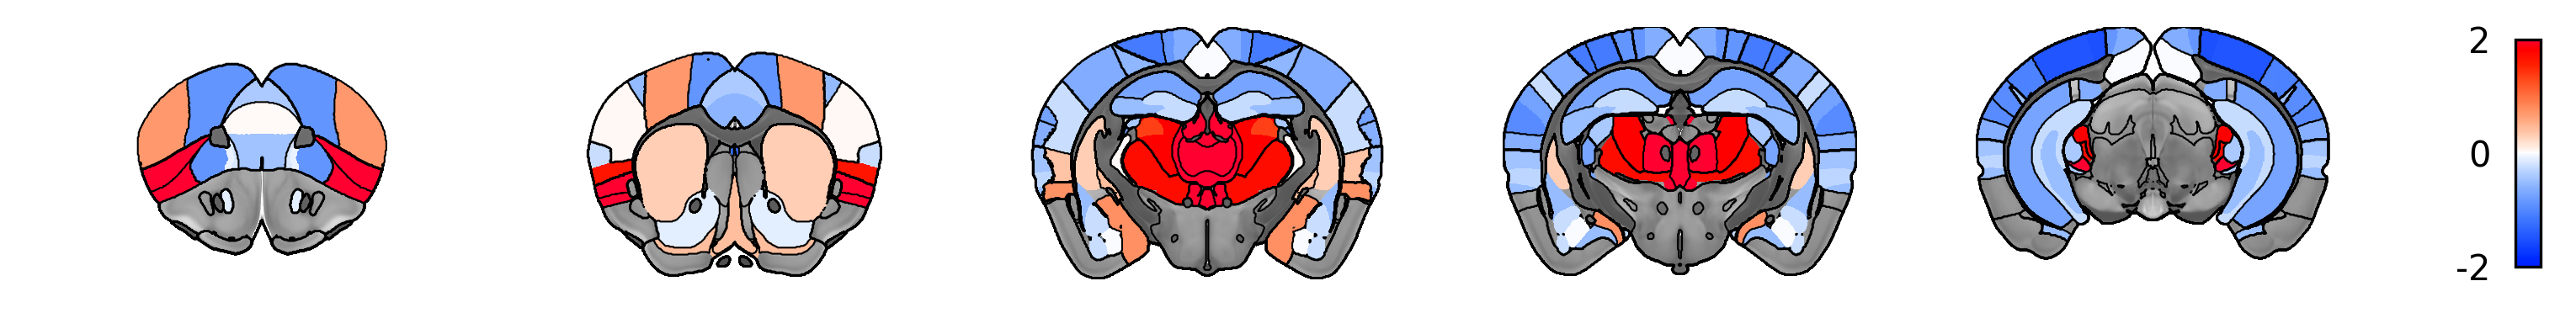

In [28]:
# view the image
plot_mouse_phenotype(phenotype_img, normalize_img=True, symmetric_cbar=True,vmax=2, threshold=0)

## Step 2: Initialization
Before starting the mapping, you need to initialize TransBrain by creating an instance of the ``SpeciesTrans`` class.

You need to specify which target human brain atlas you want to map to. You can choose ``atlas_type`` from ``['bn', 'dk', 'aal']``. During this process, TransBrain will automatically load the necessary information for the mapping, including the brain region name list and the graph embedding matrix for the selected atlas.

In [29]:
#Initialize TransBrain for bn atlas
Transformer = tb.trans.SpeciesTrans('bn')

INFO:root:Initialized for bn atlas.


## Step 3: Mapping

Now, we can map the mouse phenotype DataFrame (either loaded or extracted) to human brain, you need to choose the regions to map and whether to normalize the data. This step is enabled by default. If your data has already been normalized, you can set it to False.

In [30]:
help(Transformer.mouse_to_human)

Help on method mouse_to_human in module transbrain.trans:

mouse_to_human(phenotype: pandas.core.frame.DataFrame, region_type: Literal['cortex', 'subcortex', 'all'] = 'cortex', normalize: bool = True, restore: bool = False) -> pandas.core.frame.DataFrame method of transbrain.trans.SpeciesTrans instance
    Translate mouse phenotype to human.
    
    Parameters
    ----------
    phenotype : pd.DataFrame
        Mouse phenotype DataFrame (regions × phenotypes).
    region_type : {'cortex', 'subcortex', 'all'}, optional
        The brain region type to translate. Default is 'cortex'.
    normalize : bool, optional
        Whether to normalize data before translation. Default is True.
    restore : bool, optional
        Whether to restore values back to original scale after translation. Only used if normalize is True.
        Please enable this parameter with caution, unless you are certain that the distributions of this phenotype are consistent between the two species.
    
    Returns

In [31]:
# Example from mouse to human
mouse_phenotype_in_human = Transformer.mouse_to_human(
                            mouse_phenotype, 
                            region_type='all', 
                            normalize=True)

INFO:root:Successfully translated mouse all phenotypes to human.


Once the mapping is complete, you will see a success message. Let's take a look at the mapped data. Now, you got the DataFrame that stores the phenotype data corresponding to the Brainnetome atlas.

In [32]:
mouse_phenotype_in_human

,Phenotype
A8m,-0.036852
A8dl,-0.037943
A9l,-0.048855
A6dl,-0.023955
A6m,-0.005824
...,...
Otha,0.286260
mPFtha,0.568262
lPFtha,0.224644
rTtha,0.732510


You can also visualize what the mapped data looks like on human brain.

In [33]:
#fetch human BN atlas
human_atlas = tb.atlas.fetch_human_atlas(atlas_type='bn',region_type='all')

# map the region-level phenotype data to an image
mapped_phenotype_img = map_phenotype_to_nifti(mouse_phenotype_in_human, human_atlas)

<Figure size 3000x300 with 0 Axes>

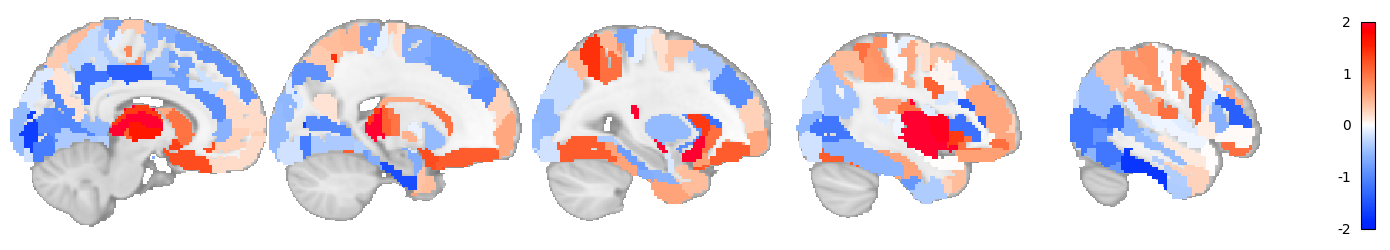

In [17]:
from transbrain.vis import plot_human_phenotype

# view the image
plot_human_phenotype(mapped_phenotype_img, normalize_img=True, cut_coords=range(10, 60, 10), vmax=2, symmetric_cbar = True)